## **1. Import Library**

In [178]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import HeatMap
import warnings
warnings.simplefilter('ignore')

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier

## **2. Read and Summarize Data**

In [179]:
df_translation = pd.read_csv('product_category_name_translation.csv')
df_customers = pd.read_csv('customers_dataset.csv')
df_geolocation = pd.read_csv('geolocation_dataset.csv')
df_order_items = pd.read_csv('order_items_dataset.csv')
df_order_payments = pd.read_csv('order_payments_dataset.csv')
df_order_reviews = pd.read_csv('order_reviews_dataset.csv')
df_orders = pd.read_csv('orders_dataset.csv')
df_products = pd.read_csv('products_dataset.csv')
df_sellers = pd.read_csv('sellers_dataset.csv')

In [180]:
df_translation.head(10).T

0                       1  \
product_category_name           beleza_saude  informatica_acessorios   
product_category_name_english  health_beauty   computers_accessories   

                                        2                3                 4  \
product_category_name          automotivo  cama_mesa_banho  moveis_decoracao   
product_category_name_english        auto   bed_bath_table   furniture_decor   

                                            5           6  \
product_category_name           esporte_lazer  perfumaria   
product_category_name_english  sports_leisure   perfumery   

                                                   7          8  \
product_category_name          utilidades_domesticas  telefonia   
product_category_name_english             housewares  telephony   

                                                9  
product_category_name          relogios_presentes  
product_category_name_english       watches_gifts

In [181]:
# Check shape of data
list_data = [df_translation ,df_customers, df_geolocation, df_order_items, df_order_payments, df_order_reviews, df_orders, df_products, df_sellers]
shape_data = [val.shape for val in list_data]

shape_data

[(71, 2),
 (99441, 5),
 (1000163, 5),
 (112650, 7),
 (103886, 5),
 (99224, 7),
 (99441, 8),
 (32951, 9),
 (3095, 4)]

In [182]:
# Summarize data using function

def summarize_data(data):
    '''
    Function to collect non-missing value for integer and float data type

    Parameters
    ----------
    data : DataFrame
        The sample data

    Returns
    -------
    summary_table : DataFrame
        The summary table of data

    '''
    # Empty list variable
    table_summary = []

    for name_column in data.columns:

        column_dtype = data[name_column].dtype # Check data type of each column

        null_total = data[name_column].isnull().sum() # Check total of missing data

        not_null_total = data[name_column].notnull().sum() # Check total of non-missing data

        percentage_null = round((null_total/len(data))*100,2) # Percentage of missing data

        percentage_not_null = round(100 - percentage_null, 2) # Percentage of non-missing data

        # Find unique value of each column
        unique_total = data[name_column].nunique()

        if unique_total <= 10:
            unique_val = data[name_column].value_counts(dropna=False).to_dict()

        else:
            top_10_val = data[name_column].value_counts(dropna=False).head(10).to_dict()
            unique_val = {k: v for k, v in sorted(top_10_val.items(), key=lambda item: item[1], reverse=True)}

        # Table summary
        table_summary.append(
            {
            'column_name': name_column,
            'column_dtype': column_dtype,
            'null_total': null_total,
            'percentage_null': percentage_null,
            'not_null_total': not_null_total,
            'percentage_not_null': percentage_not_null,
            'unique_total': unique_total,
            'unique_val': unique_val
            }
            )

    summary_table = pd.DataFrame(table_summary).sort_values(by=['percentage_null'], ascending=False)\
                    .style.format(precision=2).set_table_styles([dict(selector='th', props=[('text-align', 'center')])])\
                    .set_properties(**{'text-align': 'center'})

    return summary_table

summary_customers = summarize_data(data=df_customers)
summary_geolocation = summarize_data(data=df_geolocation)
summary_order_items = summarize_data(data=df_order_items)
summary_order_payments = summarize_data(data=df_order_payments)
summary_order_reviews = summarize_data(data=df_order_reviews)
summary_orders = summarize_data(data=df_orders)
summary_products = summarize_data(data=df_products)
summary_sellers = summarize_data(data=df_sellers)

In [183]:
summary_customers

- Data customers tidak memiliki nilai missing values di tiap kolomnya
- Terdapat 27 negara bagian tempat konsumen berada

In [184]:
summary_geolocation

- Data geolocation tidak memiliki nilai missing values di tiap kolomnya

In [185]:
summary_order_items

- Data jenis barang yang dipesan beserta harga dan ongkos kirimnya tidak memiliki nilai missing values di tiap kolomnya

In [186]:
summary_order_payments

- Data pembayaran untuk tiap pesanan tidak memiliki nilai missing values di dalamnya
- Ada 4 jenis pembayaran yang digunakan (kartu kredit, voucher, katu debit dan bank tiket (boleto))

In [187]:
summary_order_reviews

- Kolom komentar memiliki persentase nilai missing values yang cukup banyak

In [188]:
summary_orders

- Terdapat beberapa kolom dengan nilai missing values yang persentasenya cukup kecil sehingga masih bisa diolah lebih lanjut.

In [189]:
summary_products

- Terdapat beberapa kolom dengan nilai missing values yang persentasenya cukup kecil sehingga masih bisa diolah lebih lanjut.

In [190]:
summary_sellers

- Data seller tidak memiliki nilai missing values
- Terdapat 23 negara bagian tempat seller berada

## **3. Cleaning Data - Before Merging**

In [191]:
# Convert column contains time to datetime type

df_order_items['shipping_limit_date'] = pd.to_datetime(df_order_items['shipping_limit_date'])
df_order_reviews['review_creation_date'] = pd.to_datetime(df_order_reviews['review_creation_date'])
df_order_reviews['review_answer_timestamp'] = pd.to_datetime(df_order_reviews['review_answer_timestamp'])
df_orders['order_approved_at'] = pd.to_datetime(df_orders['order_approved_at'])
df_orders['order_delivered_carrier_date'] = pd.to_datetime(df_orders['order_delivered_carrier_date'])
df_orders['order_delivered_customer_date'] = pd.to_datetime(df_orders['order_delivered_customer_date'])
df_orders['order_estimated_delivery_date'] = pd.to_datetime(df_orders['order_estimated_delivery_date'])
df_orders['order_purchase_timestamp'] =pd.to_datetime(df_orders['order_purchase_timestamp'])

# Rename column

df_products = df_products.rename(columns={'product_name_lenght': 'product_name_length', 'product_description_lenght': 'product_description_length'})

## **4. Check Duplicated Data - Before Merging**

In [192]:
# Check total of duplicated data

list_data = [df_translation ,df_customers, df_geolocation, df_order_items, df_order_payments, df_order_reviews, df_orders, df_products, df_sellers]

duplicated_sum = [val.duplicated().sum() for val in list_data]

duplicated_sum


[0, 0, 261831, 0, 0, 0, 0, 0, 0]

- Data geolocation memiliki duplicated data yang cukup banyak sehingga perlu didrop untuk efisiensi penggabungan data

In [193]:
# Drop duplicated data

df_geolocation.drop_duplicates(keep='first', inplace=True)

df_geolocation.duplicated().sum()

0

## **5. Merge Data**

In [194]:
# Translate product category name in data products

translation_dict = df_translation.to_dict(orient='split')

map_translate = {}

for i in range(len(translation_dict['data'])):

    map_translate.update({translation_dict['data'][i][0]: translation_dict['data'][i][1]})

value = df_products['product_category_name'].map(map_translate)

df_products.insert(2,'product_category_name_translated',value=value, allow_duplicates=True)

In [195]:
df_products.head()

product_id  product_category_name  \
0  1e9e8ef04dbcff4541ed26657ea517e5             perfumaria   
1  3aa071139cb16b67ca9e5dea641aaa2f                  artes   
2  96bd76ec8810374ed1b65e291975717f          esporte_lazer   
3  cef67bcfe19066a932b7673e239eb23d                  bebes   
4  9dc1a7de274444849c219cff195d0b71  utilidades_domesticas   

  product_category_name_translated  product_name_length  \
0                        perfumery                 40.0   
1                              art                 44.0   
2                   sports_leisure                 46.0   
3                             baby                 27.0   
4                       housewares                 37.0   

   product_description_length  product_photos_qty  product_weight_g  \
0                       287.0                 1.0             225.0   
1                       276.0                 1.0            1000.0   
2                       250.0                 1.0             154.0   
3                       261.0                 1.0             371.0   
4                       402.0                 4.0             625.0   

   product_length_cm  product_height_cm  product_width_cm  
0               16.0               10.0              14.0  
1               30.0               18.0              20.0  
2               18.0                9.0              15.0  
3               26.0                4.0              26.0  
4               20.0               17.0              13.0

#### 1. Customer Data + Location

In [196]:
customers_location = pd.merge(df_customers, df_geolocation, how ='inner', left_on=['customer_zip_code_prefix'], right_on=['geolocation_zip_code_prefix'])

#### 2. Seller + Location

In [197]:
seller_location = pd.merge(df_sellers, df_geolocation, how ='inner', left_on=['seller_zip_code_prefix'], right_on=['geolocation_zip_code_prefix'])

#### 3. Full Merge

In [198]:
df_full = df_orders.merge(df_order_reviews, how='inner',on='order_id')\
                   .merge(df_order_payments, how='inner',on='order_id')\
                   .merge(df_customers, how='inner',on='customer_id')\
                   .merge(df_order_items, how='inner',on='order_id')\
                   .merge(df_products, how='inner',on='product_id')\
                   .merge(df_sellers, how='inner',on='seller_id')

## **6. Cleaning and Check Data After Merged**

In [199]:
# Drop and Rename column

customers_location = customers_location.drop(columns=['geolocation_zip_code_prefix','geolocation_city','geolocation_state']).rename(columns={'geolocation_lat': 'latitude', 'geolocation_lng': 'longitude'})
seller_location = seller_location.drop(columns=['geolocation_zip_code_prefix','geolocation_city','geolocation_state']).rename(columns={'geolocation_lat': 'latitude', 'geolocation_lng': 'longitude'})

In [200]:
data_merged = [customers_location, seller_location, df_full]

duplicated_merged = [val.duplicated().sum() for val in data_merged]

duplicated_merged


[256364, 7904, 0]

- Data gabungan geolocation dengan customer dan seller memiliki duplicated values yang cukup banyak sehingga perlu didrop untuk pengolahan lebih lanjut

In [201]:
customers_location.drop_duplicates(keep='first', inplace=True)

seller_location.drop_duplicates(keep='first', inplace=True)

In [202]:
# Check sample data of full merge

df_full.head().T

0  \
order_id                                           e481f51cbdc54678b7cc49136f2d6af7   
customer_id                                        9ef432eb6251297304e76186b10a928d   
order_status                                                              delivered   
order_purchase_timestamp                                        2017-10-02 10:56:33   
order_approved_at                                               2017-10-02 11:07:15   
order_delivered_carrier_date                                    2017-10-04 19:55:00   
order_delivered_customer_date                                   2017-10-10 21:25:13   
order_estimated_delivery_date                                   2017-10-18 00:00:00   
review_id                                          a54f0611adc9ed256b57ede6b6eb5114   
review_score                                                                      4   
review_comment_title                                                            NaN   
review_comment_message            Não testei o produto ainda, mas ele veio corre...   
review_creation_date                                            2017-10-11 00:00:00   
review_answer_timestamp                                         2017-10-12 03:43:48   
payment_sequential                                                                1   
payment_type                                                            credit_card   
payment_installments                                                              1   
payment_value                                                                 18.12   
customer_unique_id                                 7c396fd4830fd04220f754e42b4e5bff   
customer_zip_code_prefix                                                       3149   
customer_city                                                             sao paulo   
customer_state                                                                   SP   
order_item_id                                                                     1   
product_id                                         87285b34884572647811a353c7ac498a   
seller_id                                          3504c0cb71d7fa48d967e0e4c94d59d9   
shipping_limit_date                                             2017-10-06 11:07:15   
price                                                                         29.99   
freight_value                                                                  8.72   
product_category_name                                         utilidades_domesticas   
product_category_name_translated                                         housewares   
product_name_length                                                            40.0   
product_description_length                                                    268.0   
product_photos_qty                                                              4.0   
product_weight_g                                                              500.0   
product_length_cm                                                              19.0   
product_height_cm                                                               8.0   
product_width_cm                                                               13.0   
seller_zip_code_prefix                                                         9350   
seller_city                                                                    maua   
seller_state                                                                     SP   

                                                                                  1  \
order_id                                           e481f51cbdc54678b7cc49136f2d6af7   
customer_id                                        9ef432eb6251297304e76186b10a928d   
order_status                                                              delivered   
order_purchase_timestamp                                        2017-10-02 10:56:33   
order_approved_at                                               2017-10-02 11:0

In [203]:
summarize_data(data=df_full)

## **7. Analysis**

Analisis yang dilakukan dalam studi kasus ini adalah **geoanalysis**, **order status by state**, **order by city**, **orders hourly, daily & monthly**, **order reviews**, **products by customer & seller state**, dan **RFM Segmentation**.

#### 1. Geonalysis

In [204]:
# Group by 'seller_id' and calculate the mean latitude and longitude for each unique seller
unique_sellers_df = seller_location.groupby('seller_id').agg({
    'latitude': 'mean',
    'longitude': 'mean'
}).reset_index()

# Create a base map centered around the center of Brazil
sellers_map = folium.Map(location=[-14.2350, -51.9253], tiles='cartodbpositron', zoom_start=4.5)

# Add a heatmap to the base map using the unique seller locations
HeatMap(data=unique_sellers_df[['latitude', 'longitude']], radius=10).add_to(sellers_map)

# Display the map
sellers_map

In [205]:
sellers_map.save('unique_sellers_map.html')

Sebagian besar penjual barang atau seller terkonsentrasi di negara bagian SP (Sao Paulo) dan RJ (Rio de Janeiro).

In [206]:
# Group by 'customer_unique_id' and calculate the mean latitude and longitude for each unique customer
df_unique_customers = customers_location.groupby('customer_unique_id').agg({
    'latitude': 'mean',
    'longitude': 'mean'
}).reset_index()

# Create a base map centered around the center of Brazil
customers_map = folium.Map(location=[-14.2350, -51.9253], tiles='cartodbpositron', zoom_start=4.5)

# Add a heatmap to the base map using the unique seller locations
HeatMap(data=df_unique_customers[['latitude', 'longitude']], radius=10).add_to(customers_map)

# Display the map
customers_map

In [207]:
customers_map.save('customers_map.html')

Berdasarkan hasil geonalisis, terlihat bahwa sebagian besar konsumen berada di negara bagian SP (Sao Paulo) dan RJ (Rio de Janeiro). Persebaran konsumen cenderung lebih merata dibandingkan persebaran sellernya.

In [208]:
map_name = {
    'AC': 'Acre',
    'AL': 'Alagoas',
    'AP': 'Amapá',
    'AM': 'Amazonas',
    'BA': 'Bahia',
    'CE': 'Ceará',
    'DF': 'Distrito Federal',
    'ES': 'Espírito Santo',
    'GO': 'Goiás',
    'MA': 'Maranhão',
    'MT': 'Mato Grosso',
    'MS': 'Mato Grosso do Sul',
    'MG': 'Minas Gerais',
    'PA': 'Pará',
    'PB': 'Paraíba',
    'PR': 'Paraná',
    'PE': 'Pernambuco',
    'PI': 'Piauí',
    'RJ': 'Rio de Janeiro',
    'RN': 'Rio Grande do Norte',
    'RS': 'Rio Grande do Sul',
    'RO': 'Rondônia',
    'RR': 'Roraima',
    'SC': 'Santa Catarina',
    'SP': 'São Paulo',
    'SE': 'Sergipe',
    'TO': 'Tocantins'
}

customer_state = pd.DataFrame(round(customers_location['customer_state'].value_counts(normalize=True)*100,2)).reset_index().rename(columns={'proportion':'Percentage'})
seller_state = pd.DataFrame(round(seller_location['seller_state'].value_counts(normalize=True)*100,2)).reset_index().rename(columns={'proportion':'Percentage'})
customer_state['State_name'] = customer_state['customer_state'].map(map_name)
seller_state['State_name'] = seller_state['seller_state'].map(map_name)

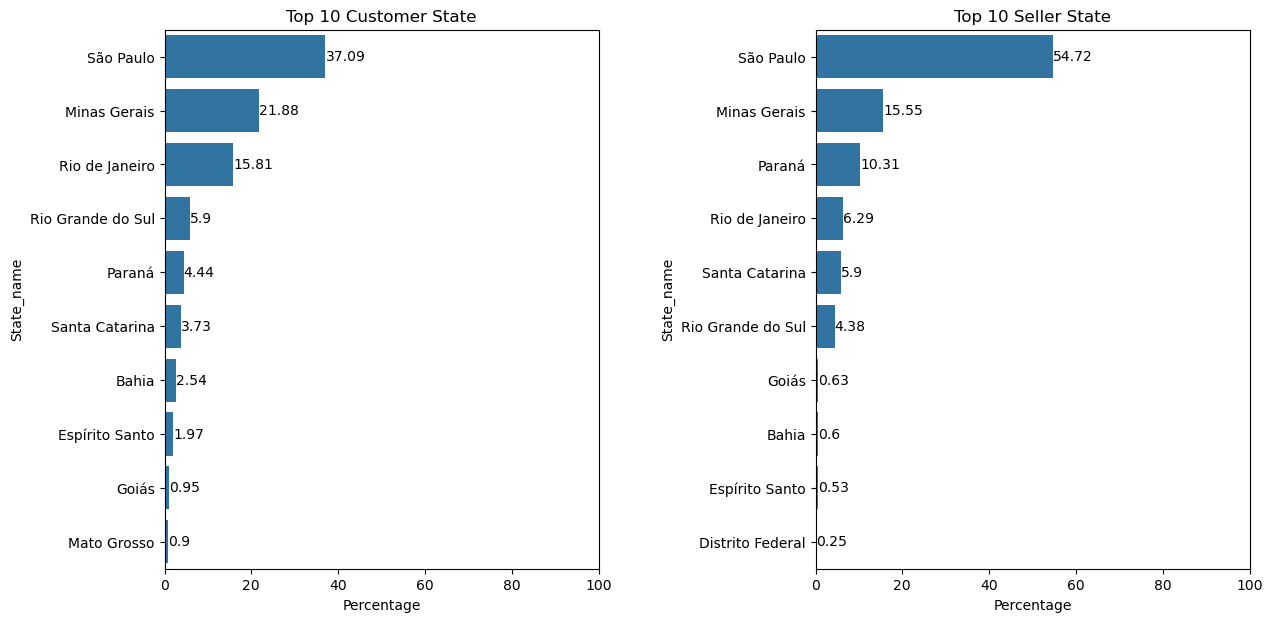

In [209]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14,7), sharex=True)

plt.subplots_adjust(wspace=0.5, hspace=0.5)

ax1 = sns.barplot(data = customer_state.loc[0:9], y='State_name', x='Percentage', ax=ax[0], orient='h')
ax2 = sns.barplot(data = seller_state.loc[0:9], y='State_name', x='Percentage', ax=ax[1], orient='h')

for i in ax1.containers:
    ax1.bar_label(i,)

for i in ax2.containers:
    ax2.bar_label(i,)

ax1.set_title('Top 10 Customer State')
ax2.set_title('Top 10 Seller State')

plt.xlim(0,100)
plt.savefig('Top 10 Customer and Seller State.png', bbox_inches='tight')
plt.show()

- Grafik Top 10 Customer State menunjukkan bahwa sekitar 37% konsumen berada di negara bagian SP (Sao Paulo). Sedangkan untuk Top 10 Seller State, sekitar 54.72% seller berada di negara bagian SP (Sao Paulo)

#### 2. Order Status by State

In [210]:
status_state = pd.DataFrame(round(df_full['order_status'].value_counts(normalize=True)*100,2)).reset_index().rename(columns={'proportion':'Percentage'})
status_state

order_status  Percentage
0    delivered       97.89
1      shipped        0.99
2     canceled        0.47
3     invoiced        0.32
4   processing        0.32
5  unavailable        0.01
6     approved        0.00

In [211]:
state_delivered = pd.DataFrame(df_full[df_full['order_status'] == 'delivered'].groupby(['customer_state'])['customer_state'].count())\
                .rename(columns={'customer_state': 'Total'}).reset_index().sort_values(by=['Total'], ascending=False, ignore_index=True)

state_delivered['State_name'] = state_delivered['customer_state'].map(map_name)

state_delivered

customer_state  Total           State_name
0              SP  48517            São Paulo
1              RJ  14786       Rio de Janeiro
2              MG  13403         Minas Gerais
3              RS   6412    Rio Grande do Sul
4              PR   5868               Paraná
5              SC   4204       Santa Catarina
6              BA   3915                Bahia
7              DF   2429     Distrito Federal
8              GO   2360                Goiás
9              ES   2287       Espírito Santo
10             PE   1820           Pernambuco
11             CE   1497                Ceará
12             PA   1076                 Pará
13             MT   1071          Mato Grosso
14             MS    846   Mato Grosso do Sul
15             MA    817             Maranhão
16             PB    614              Paraíba
17             RN    559  Rio Grande do Norte
18             PI    548                Piauí
19             AL    442              Alagoas
20             SE    384              Sergipe
21             TO    333            Tocantins
22             RO    280             Rondônia
23             AM    169             Amazonas
24             AC     94                 Acre
25             AP     82                Amapá
26             RR     46              Roraima

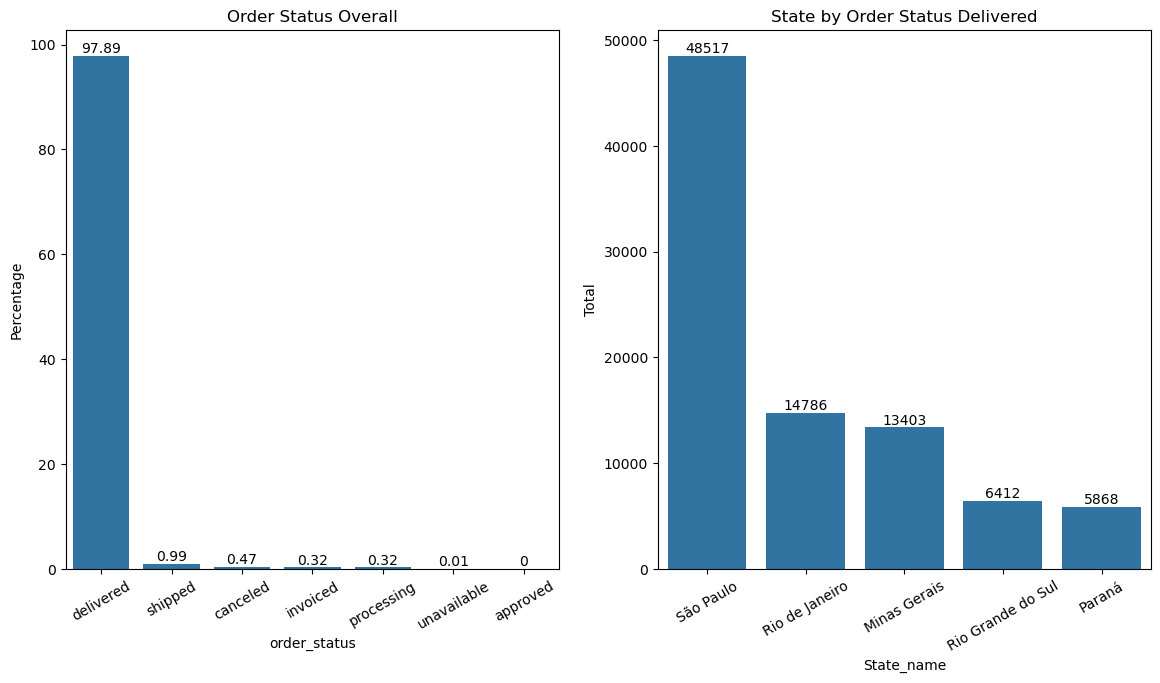

In [212]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14,7))

ax1 = sns.barplot(data = status_state, x='order_status', y='Percentage', ax=ax[0], orient='v')
ax2 = sns.barplot(data = state_delivered.loc[0:4], x='State_name', y='Total', ax=ax[1], orient='v')

for i in ax1.containers:
    ax1.bar_label(i,)

for i in ax2.containers:
    ax2.bar_label(i,)

ax1.set_xticklabels(labels=status_state['order_status'],rotation=30)
ax1.set_title('Order Status Overall')
ax2.set_xticklabels(labels=state_delivered['State_name'], rotation=30)
ax2.set_title('State by Order Status Delivered')

plt.savefig('Order Status.png', bbox_inches='tight')
plt.show()

- Sebanyak 97.89% status pengiriman barang adalah delivered, artinya E-Commerce tersebut memiliki tingkat pengiriman yang sangat baik.
- Sebanyak 48517 konsumen dengan status pengiriman delivered berada di negara bagian SP (Sao Paolo).

#### 3. Orders by City

In [213]:
state_order = pd.DataFrame(df_full['customer_city'].str.title().value_counts()).reset_index()

state_order

customer_city  count
0           Sao Paulo  18582
1      Rio De Janeiro   8158
2      Belo Horizonte   3252
3            Brasilia   2466
4            Curitiba   1807
...               ...    ...
4103      Sao Nicolau      1
4104    Felipe Guerra      1
4105      Aguas Frias      1
4106        Quatituba      1
4107  Canto Do Buriti      1

[4108 rows x 2 columns]

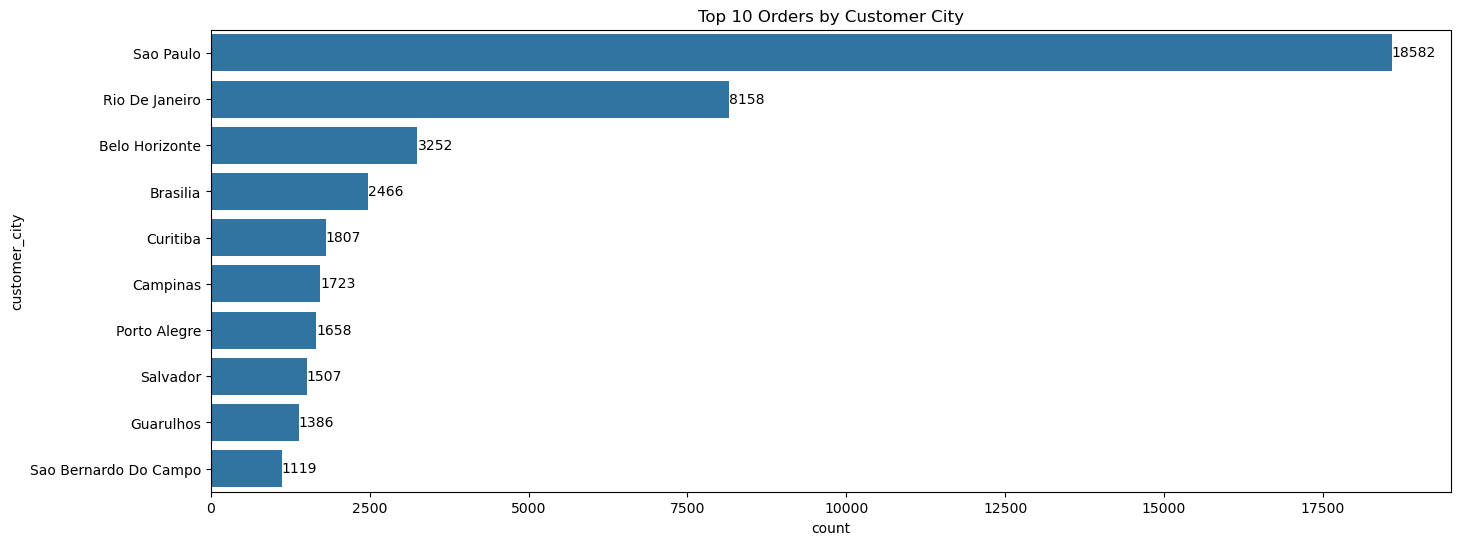

In [214]:
fig, ax = plt.subplots(figsize=(16,6))

ax = sns.barplot(data=state_order.loc[0:9], x='count', y='customer_city')

for i in ax.containers:
    ax.bar_label(i,)

ax.set_title('Top 10 Orders by Customer City')

plt.savefig('Top 10 Orders by Customers City.png', bbox_inches='tight')
plt.show()

- Jumlah konsumen yang melakukan order di negara bagian SP (Sao Paulo) jauh lebih banyak dibandingkan negara bagian lainnya.

#### 4. Orders Hourly, Daily, & Monthly

In [215]:
order_time = df_full[['order_purchase_timestamp','customer_city','customer_state']]

sorted_weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
sorted_month = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

order_time['Day'] = order_time['order_purchase_timestamp'].dt.day_name()
order_time['Day'] = pd.Categorical(order_time['Day'], sorted_weekdays)
order_time['Hour'] = order_time['order_purchase_timestamp'].dt.hour
order_time['Month'] = order_time['order_purchase_timestamp'].dt.month_name()
order_time['Month'] = pd.Categorical(order_time['Month'], sorted_month)
order_time['Year'] = order_time['order_purchase_timestamp'].dt.year

In [216]:
map_day = {
    'Monday': 1,
    'Tuesday': 2,
    'Wednesday': 3,
    'Thursday': 4,
    'Friday': 5,
    'Saturday': 6,
    'Sunday': 0
}

order_time['Day_Int'] = order_time['Day'].map(map_day)
order_time['State_name'] = order_time['customer_state'].map(map_name)

order_time

order_purchase_timestamp          customer_city customer_state  \
0           2017-10-02 10:56:33              sao paulo             SP   
1           2017-10-02 10:56:33              sao paulo             SP   
2           2017-10-02 10:56:33              sao paulo             SP   
3           2017-08-15 18:29:31              sao paulo             SP   
4           2017-08-02 18:24:47              sao paulo             SP   
...                         ...                    ...            ...   
117324      2018-07-01 10:23:10  ferraz de vasconcelos             SP   
117325      2017-03-11 19:51:36                 gaspar             SC   
117326      2018-07-24 09:46:27              fortaleza             CE   
117327      2018-05-22 21:13:21          teofilo otoni             MG   
117328      2018-05-15 17:41:00  sao bernardo do campo             SP   

              Day  Hour    Month  Year Day_Int      State_name  
0          Monday    10  October  2017       1       São Paulo  
1          Monday    10  October  2017       1       São Paulo  
2          Monday    10  October  2017       1       São Paulo  
3         Tuesday    18   August  2017       2       São Paulo  
4       Wednesday    18   August  2017       3       São Paulo  
...           ...   ...      ...   ...     ...             ...  
117324     Sunday    10     July  2018       0       São Paulo  
117325   Saturday    19    March  2017       6  Santa Catarina  
117326    Tuesday     9     July  2018       2           Ceará  
117327    Tuesday    21      May  2018       2    Minas Gerais  
117328    Tuesday    17      May  2018       2       São Paulo  

[117329 rows x 9 columns]

In [217]:
pivot_day = pd.pivot_table(order_time, columns='Hour', index='Day', values='Day_Int', aggfunc='count').sort_values(by=['Day']).style.background_gradient(cmap='YlGnBu')

pivot_day

- Order yang dilakukan konsumen cenderung lebih banyak di hari kerja, khususnya di hari Senin pada jam 10 - 16.

In [218]:
pivot_state = pd.pivot_table(order_time, columns='Hour', index='State_name', values='Day', aggfunc='count').sort_values(by=['State_name'], ascending=False).fillna(0).style.background_gradient(cmap='YlGnBu').format(precision=0)

pivot_state

- Konsumer di negara bagian SP (Sao Paulo) merupakan penyumbang order terbesar pada jam 10-16. Diikuti konsumer di negara bagian RJ (Rio de Janeiro) dan MG (Minas Gerais)

In [219]:
pivot_month = pd.pivot_table(order_time, columns='Day',index=['Year','Month'],values='customer_state', aggfunc='count').style.background_gradient(cmap='YlGnBu')

pivot_month

- Bulan November 2017 - May 2018 merupakan puncak jumlah order dari seluruh negara bagian.

#### 5. Products by Consumer State & Seller State

In [220]:
df_full['state_name_customer'] = df_full['customer_state'].map(map_name)
df_full['state_name_seller'] = df_full['seller_state'].map(map_name)


In [221]:
top_10_products = pd.DataFrame(df_full['product_category_name_translated'].value_counts()).reset_index().loc[0:9]

top_10_products

product_category_name_translated  count
0                   bed_bath_table  11847
1                    health_beauty   9944
2                   sports_leisure   8942
3                  furniture_decor   8743
4            computers_accessories   8105
5                       housewares   7331
6                    watches_gifts   6161
7                        telephony   4692
8                     garden_tools   4558
9                             auto   4356

In [222]:
seller_products_filter = df_full[df_full['product_category_name_translated'].isin(top_10_products['product_category_name_translated'])]

seller_products_state = pd.DataFrame(seller_products_filter[['state_name_seller','product_category_name_translated']].value_counts()).reset_index()

In [223]:
customer_products_filter = df_full[df_full['product_category_name_translated'].isin(top_10_products['product_category_name_translated'])]

customer_products_state = pd.DataFrame(customer_products_filter[['state_name_customer','product_category_name_translated']].value_counts()).reset_index()

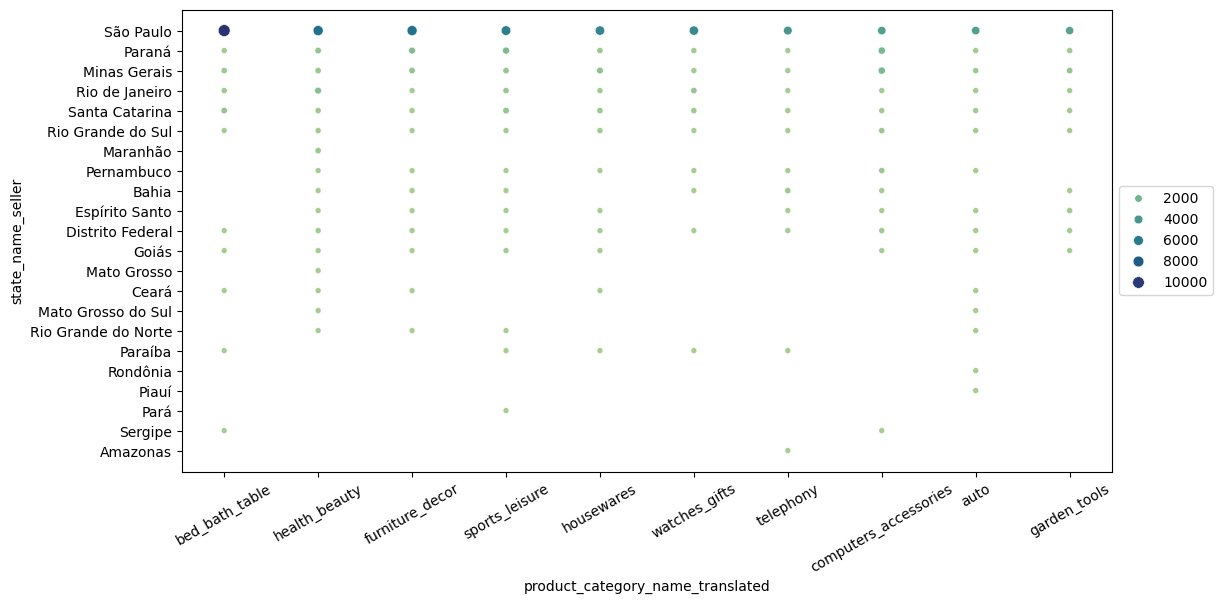

In [224]:
fig, ax = plt.subplots(figsize=(12,6))

sns.scatterplot(data=seller_products_state, x='product_category_name_translated', y='state_name_seller', size='count', hue='count', palette='crest')

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.xticks(rotation=30)
plt.savefig('Top 10 Product Category by Seller State.png', bbox_inches='tight')
plt.show()

- Seller di negara bagian SP (Sao Paulo) merupakan seller dengan produk kategori yang paling banyak menjual untuk top 10 produk kategori, dimana bed_bath_table merupakan produk yang banyak dipesan.

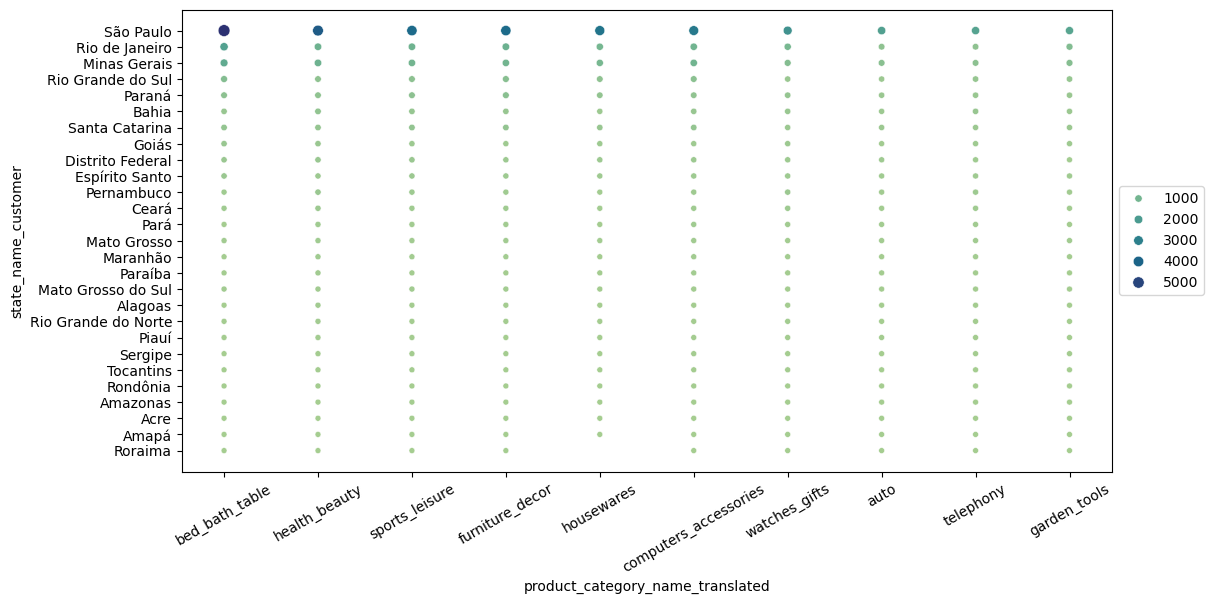

In [225]:
fig, ax = plt.subplots(figsize=(12,6))

sns.scatterplot(data=customer_products_state, x='product_category_name_translated', y='state_name_customer', size='count', hue='count', palette='crest')

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.xticks(rotation=30)
plt.savefig('Top 10 Product Category by Customer State.png', bbox_inches='tight')
plt.show()

- Konsumer di negara bagian SP (Sao Paulo) melakukan order paling banyak untuk top 10 produk kategori, dengan bed_bath_table merupakan produk kategori yang paling banyak dipesan.

#### 6. Order Reviews

In [226]:
review_score = pd.DataFrame(round(df_full['review_score'].value_counts(normalize=True)*100,2)).reset_index()\
                .rename(columns={'proportion': 'Percentage'})

review_score

review_score  Percentage
0             5       56.48
1             4       18.99
2             1       12.66
3             3        8.39
4             2        3.48

In [227]:
review_score_delivered = pd.DataFrame(round(df_full[df_full['order_status'] == 'delivered']['review_score'].value_counts(normalize=True)*100,2)).reset_index()\
                        .rename(columns={'proportion': 'Percentage'})

review_score_delivered

review_score  Percentage
0             5       57.50
1             4       19.28
2             1       11.42
3             3        8.40
4             2        3.39

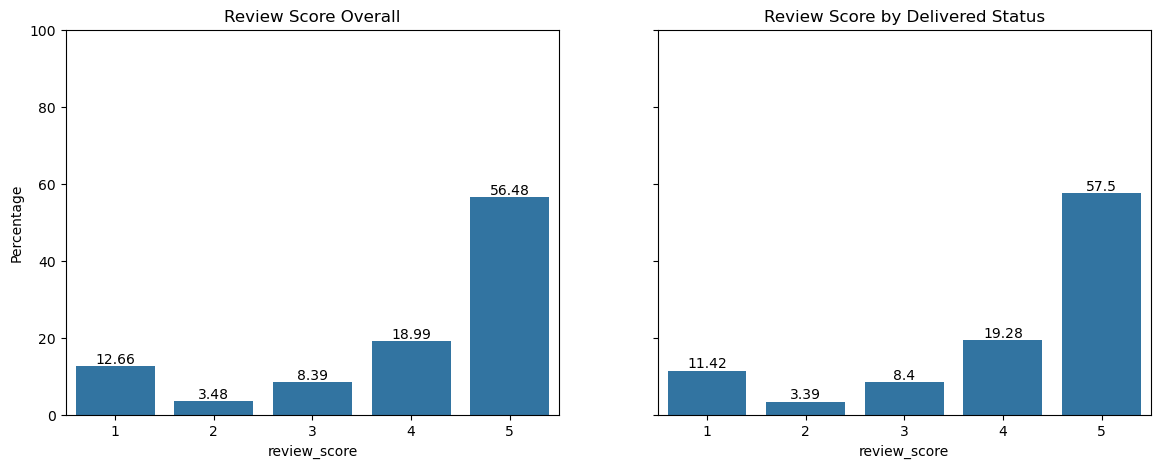

In [228]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14,5), sharey=True)

#plt.subplots_adjust(wspace=0.5, hspace=0.5)

ax1 = sns.barplot(data = review_score, x='review_score', y='Percentage', ax=ax[0])
ax2 = sns.barplot(data = review_score_delivered, x='review_score', y='Percentage', ax=ax[1])

for i in ax1.containers:
    ax1.bar_label(i,)

for i in ax2.containers:
    ax2.bar_label(i,)

ax1.set_title('Review Score Overall')
ax2.set_title('Review Score by Delivered Status')

plt.ylim(0,100)
plt.savefig('Review Score.png', bbox_inches='tight')
plt.show()

- Review score yang diterima E-Commerce tersebut sebagian besar adalah skor 5 (56.48%). Namun E-Commerce juga memiliki skor 1 dengan persentase yang cukup besar (12.66%).
- Jika melihat status pengiriman delivered, persentase review skor yang diterima tidak jauh berbeda.

#### 7. RFM Segmentation

In [229]:
df_full['date_purchase'] = df_full['order_purchase_timestamp'].dt.date

df_full['total_spent'] = df_full['price'] + df_full['freight_value']

df_full.head()

order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
2  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
3  128e10d95713541c87cd1a2e48201934  a20e8105f23924cd00833fd87daa0831   
4  0e7e841ddf8f8f2de2bad69267ecfbcf  26c7ac168e1433912a51b924fbd34d34   

  order_status order_purchase_timestamp   order_approved_at  \
0    delivered      2017-10-02 10:56:33 2017-10-02 11:07:15   
1    delivered      2017-10-02 10:56:33 2017-10-02 11:07:15   
2    delivered      2017-10-02 10:56:33 2017-10-02 11:07:15   
3    delivered      2017-08-15 18:29:31 2017-08-15 20:05:16   
4    delivered      2017-08-02 18:24:47 2017-08-02 18:43:15   

  order_delivered_carrier_date order_delivered_customer_date  \
0          2017-10-04 19:55:00           2017-10-10 21:25:13   
1          2017-10-04 19:55:00           2017-10-10 21:25:13   
2          2017-10-04 19:55:00           2017-10-10 21:25:13   
3          2017-08-17 15:28:33           2017-08-18 14:44:43   
4          2017-08-04 17:35:43           2017-08-07 18:30:01   

  order_estimated_delivery_date                         review_id  \
0                    2017-10-18  a54f0611adc9ed256b57ede6b6eb5114   
1                    2017-10-18  a54f0611adc9ed256b57ede6b6eb5114   
2                    2017-10-18  a54f0611adc9ed256b57ede6b6eb5114   
3                    2017-08-28  b46f1e34512b0f4c74a72398b03ca788   
4                    2017-08-15  dc90f19c2806f1abba9e72ad3c350073   

   review_score  ... product_length_cm product_height_cm product_width_cm  \
0             4  ...              19.0               8.0             13.0   
1             4  ...              19.0               8.0             13.0   
2             4  ...              19.0               8.0             13.0   
3             4  ...              19.0               8.0             13.0   
4             5  ...              19.0               8.0             13.0   

  seller_zip_code_prefix  seller_city seller_state  state_name_customer  \
0                   9350         maua           SP            São Paulo   
1                   9350         maua           SP            São Paulo   
2                   9350         maua           SP            São Paulo   
3                   9350         maua           SP            São Paulo   
4                   9350         maua           SP            São Paulo   

   state_name_seller date_purchase  total_spent  
0          São Paulo    2017-10-02        38.71  
1          São Paulo    2017-10-02        38.71  
2          São Paulo    2017-10-02        38.71  
3          São Paulo    2017-08-15        37.77  
4          São Paulo    2017-08-02        37.77  

[5 rows x 44 columns]

In [230]:
customer_item_filter = df_full[df_full['order_status'] == 'delivered']

customer_item_filter = customer_item_filter.drop_duplicates(subset=['order_id','customer_id'], keep='first')

customer_item_filter.head()

order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
3  128e10d95713541c87cd1a2e48201934  a20e8105f23924cd00833fd87daa0831   
4  0e7e841ddf8f8f2de2bad69267ecfbcf  26c7ac168e1433912a51b924fbd34d34   
5  bfc39df4f36c3693ff3b63fcbea9e90a  53904ddbea91e1e92b2b3f1d09a7af86   
6  8736140c61ea584cb4250074756d8f3b  ab8844663ae049fda8baf15fc928f47f   

  order_status order_purchase_timestamp   order_approved_at  \
0    delivered      2017-10-02 10:56:33 2017-10-02 11:07:15   
3    delivered      2017-08-15 18:29:31 2017-08-15 20:05:16   
4    delivered      2017-08-02 18:24:47 2017-08-02 18:43:15   
5    delivered      2017-10-23 23:26:46 2017-10-25 02:14:11   
6    delivered      2017-08-10 13:35:55 2017-08-10 13:50:09   

  order_delivered_carrier_date order_delivered_customer_date  \
0          2017-10-04 19:55:00           2017-10-10 21:25:13   
3          2017-08-17 15:28:33           2017-08-18 14:44:43   
4          2017-08-04 17:35:43           2017-08-07 18:30:01   
5          2017-10-27 16:48:46           2017-11-07 18:04:59   
6          2017-08-11 13:52:35           2017-08-16 19:03:36   

  order_estimated_delivery_date                         review_id  \
0                    2017-10-18  a54f0611adc9ed256b57ede6b6eb5114   
3                    2017-08-28  b46f1e34512b0f4c74a72398b03ca788   
4                    2017-08-15  dc90f19c2806f1abba9e72ad3c350073   
5                    2017-11-13  1bafb430e498b939f258b9c9dbdff9b1   
6                    2017-08-23  b8238c6515192f8129081e17dc57d169   

   review_score  ... product_length_cm product_height_cm product_width_cm  \
0             4  ...              19.0               8.0             13.0   
3             4  ...              19.0               8.0             13.0   
4             5  ...              19.0               8.0             13.0   
5             3  ...              19.0               8.0             13.0   
6             5  ...              20.0              10.0             15.0   

  seller_zip_code_prefix  seller_city seller_state  state_name_customer  \
0                   9350         maua           SP            São Paulo   
3                   9350         maua           SP            São Paulo   
4                   9350         maua           SP            São Paulo   
5                   9350         maua           SP       Santa Catarina   
6                   9350         maua           SP            São Paulo   

   state_name_seller date_purchase  total_spent  
0          São Paulo    2017-10-02        38.71  
3          São Paulo    2017-08-15        37.77  
4          São Paulo    2017-08-02        37.77  
5          São Paulo    2017-10-23        44.09  
6          São Paulo    2017-08-10        83.69  

[5 rows x 44 columns]

In [231]:
customer_item_filter[['customer_unique_id']].value_counts()

customer_unique_id              
8d50f5eadf50201ccdcedfb9e2ac8455    15
3e43e6105506432c953e165fb2acf44c     9
ca77025e7201e3b30c44b472ff346268     7
6469f99c1f9dfae7733b25662e7f1782     7
1b6c7548a2a1f9037c1fd3ddfed95f33     7
                                    ..
5655967ad654dc2d2affca3502631db7     1
56556a95d541c4ca3745744d9aeebc00     1
56550de806540216e8a5fd85d5597678     1
565482c4a27a7c7f86870a5ab4ea0a85     1
ffffd2657e2aad2907e67c3e9daecbeb     1
Name: count, Length: 92754, dtype: int64

In [232]:
max_date_purchase = customer_item_filter['date_purchase'].max()

max_date_purchase

datetime.date(2018, 8, 29)

In [233]:
import datetime as dt

set_max_date = dt.date(2018, 12, 31)

set_max_date

datetime.date(2018, 12, 31)

In [234]:
df_rfm = customer_item_filter.groupby(['customer_unique_id'])\
        .agg({'order_id': 'count','date_purchase':'max', 'total_spent': 'sum'}).reset_index()

df_rfm.columns = ['customer_unique_id', 'Frequency', 'last_date_purchase', 'Monetary']
df_rfm['Recency'] = df_rfm['last_date_purchase'].apply(lambda x: (set_max_date - x).days)
df_rfm = df_rfm.drop(columns=['last_date_purchase'])

df_rfm

customer_unique_id  Frequency  Monetary  Recency
0      0000366f3b9a7992bf8c76cfdf3221e2          1    141.90      235
1      0000b849f77a49e4a4ce2b2a4ca5be3f          1     27.19      238
2      0000f46a3911fa3c0805444483337064          1     86.22      661
3      0000f6ccb0745a6a4b88665a16c9f078          1     43.62      445
4      0004aac84e0df4da2b147fca70cf8255          1    196.89      412
...                                 ...        ...       ...      ...
92749  fffcf5a5ff07b0908bd4e2dbc735a684          1    919.14      571
92750  fffea47cd6d3cc0a88bd621562a9d061          1     84.58      386
92751  ffff371b4d645b6ecea244b27531430a          1    112.46      692
92752  ffff5962728ec6157033ef9805bacc48          1    133.69      243
92753  ffffd2657e2aad2907e67c3e9daecbeb          1     71.56      608

[92754 rows x 4 columns]

In [235]:
quantiles = df_rfm.set_index('customer_unique_id').quantile(q=[0.25,0.5,0.75])
quantiles

Frequency  Monetary  Recency
0.25        1.0     58.27    238.0
0.50        1.0     98.61    342.0
0.75        1.0    166.80    470.0

In [236]:
quantiles.to_dict()

{'Frequency': {0.25: 1.0, 0.5: 1.0, 0.75: 1.0},
 'Monetary': {0.25: 58.27, 0.5: 98.61, 0.75: 166.8},
 'Recency': {0.25: 238.0, 0.5: 342.0, 0.75: 470.0}}

In [237]:
# Arguments (x = value, p = recency, monetary_value, frequency, d = quartiles dict)
def R_score(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4
# Arguments (x = value, p = recency, monetary_value, frequency, d = quartiles dict)
def FM_score(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1

In [238]:
#create rfm segmentation table
rfm_segmentation = df_rfm.set_index('customer_unique_id')
rfm_segmentation['F_Quartile'] = rfm_segmentation['Frequency'].apply(FM_score, args=('Frequency',quantiles,))
rfm_segmentation['M_Quartile'] = rfm_segmentation['Monetary'].apply(FM_score, args=('Monetary',quantiles,))
rfm_segmentation['R_Quartile'] = rfm_segmentation['Recency'].apply(R_score, args=('Recency',quantiles,))

In [239]:
rfm_segmentation.head()

Frequency  Monetary  Recency  F_Quartile  \
customer_unique_id                                                           
0000366f3b9a7992bf8c76cfdf3221e2          1    141.90      235           4   
0000b849f77a49e4a4ce2b2a4ca5be3f          1     27.19      238           4   
0000f46a3911fa3c0805444483337064          1     86.22      661           4   
0000f6ccb0745a6a4b88665a16c9f078          1     43.62      445           4   
0004aac84e0df4da2b147fca70cf8255          1    196.89      412           4   

                                  M_Quartile  R_Quartile  
customer_unique_id                                        
0000366f3b9a7992bf8c76cfdf3221e2           2           1  
0000b849f77a49e4a4ce2b2a4ca5be3f           4           1  
0000f46a3911fa3c0805444483337064           3           4  
0000f6ccb0745a6a4b88665a16c9f078           4           3  
0004aac84e0df4da2b147fca70cf8255           1           3

In [240]:
rfm_segmentation['RFM_Group'] = rfm_segmentation['R_Quartile'].map(str) + rfm_segmentation['F_Quartile'].map(str) + rfm_segmentation['M_Quartile'].map(str)
rfm_segmentation.head()

Frequency  Monetary  Recency  F_Quartile  \
customer_unique_id                                                           
0000366f3b9a7992bf8c76cfdf3221e2          1    141.90      235           4   
0000b849f77a49e4a4ce2b2a4ca5be3f          1     27.19      238           4   
0000f46a3911fa3c0805444483337064          1     86.22      661           4   
0000f6ccb0745a6a4b88665a16c9f078          1     43.62      445           4   
0004aac84e0df4da2b147fca70cf8255          1    196.89      412           4   

                                  M_Quartile  R_Quartile RFM_Group  
customer_unique_id                                                  
0000366f3b9a7992bf8c76cfdf3221e2           2           1       142  
0000b849f77a49e4a4ce2b2a4ca5be3f           4           1       144  
0000f46a3911fa3c0805444483337064           3           4       443  
0000f6ccb0745a6a4b88665a16c9f078           4           3       344  
0004aac84e0df4da2b147fca70cf8255           1           3       341

In [241]:
best_customers = len(rfm_segmentation[rfm_segmentation['RFM_Group']=='111'])
loyal_customers = len(rfm_segmentation[rfm_segmentation['F_Quartile']==1])
big_spenders = len(rfm_segmentation[rfm_segmentation['M_Quartile']==1])
almost_lost = len(rfm_segmentation[rfm_segmentation['RFM_Group']=='311'])
lost_customers = len(rfm_segmentation[rfm_segmentation['RFM_Group']=='411'])
lost_cheap_customers = len(rfm_segmentation[rfm_segmentation['RFM_Group']=='444'])
total_rfm = best_customers + loyal_customers + big_spenders + almost_lost + lost_customers + lost_cheap_customers


summary_rfm = {
    "Best Customers" : len(rfm_segmentation[rfm_segmentation['RFM_Group']=='111']),
    "Loyal Customers" : len(rfm_segmentation[rfm_segmentation['F_Quartile']==1]),
    "Big Spenders" : len(rfm_segmentation[rfm_segmentation['M_Quartile']==1]),
    "Almost Lost" : len(rfm_segmentation[rfm_segmentation['RFM_Group']=='311']),
    "Lost Customers" : len(rfm_segmentation[rfm_segmentation['RFM_Group']=='411']),
    "Lost Cheap Customers" : len(rfm_segmentation[rfm_segmentation['RFM_Group']=='444']),
    "Others": len(rfm_segmentation) - total_rfm        
}

summary_rfm = pd.DataFrame(pd.Series(summary_rfm)).reset_index().rename(columns={'index': 'Customer Category', 0: 'Total'})
summary_rfm['Percentage'] = round((summary_rfm['Total']/sum(summary_rfm['Total']))*100,2)
summary_rfm

Customer Category  Total  Percentage
0        Best Customers    495        0.53
1       Loyal Customers   2764        2.98
2          Big Spenders  23186       25.00
3           Almost Lost    402        0.43
4        Lost Customers    323        0.35
5  Lost Cheap Customers   5921        6.38
6                Others  59663       64.32

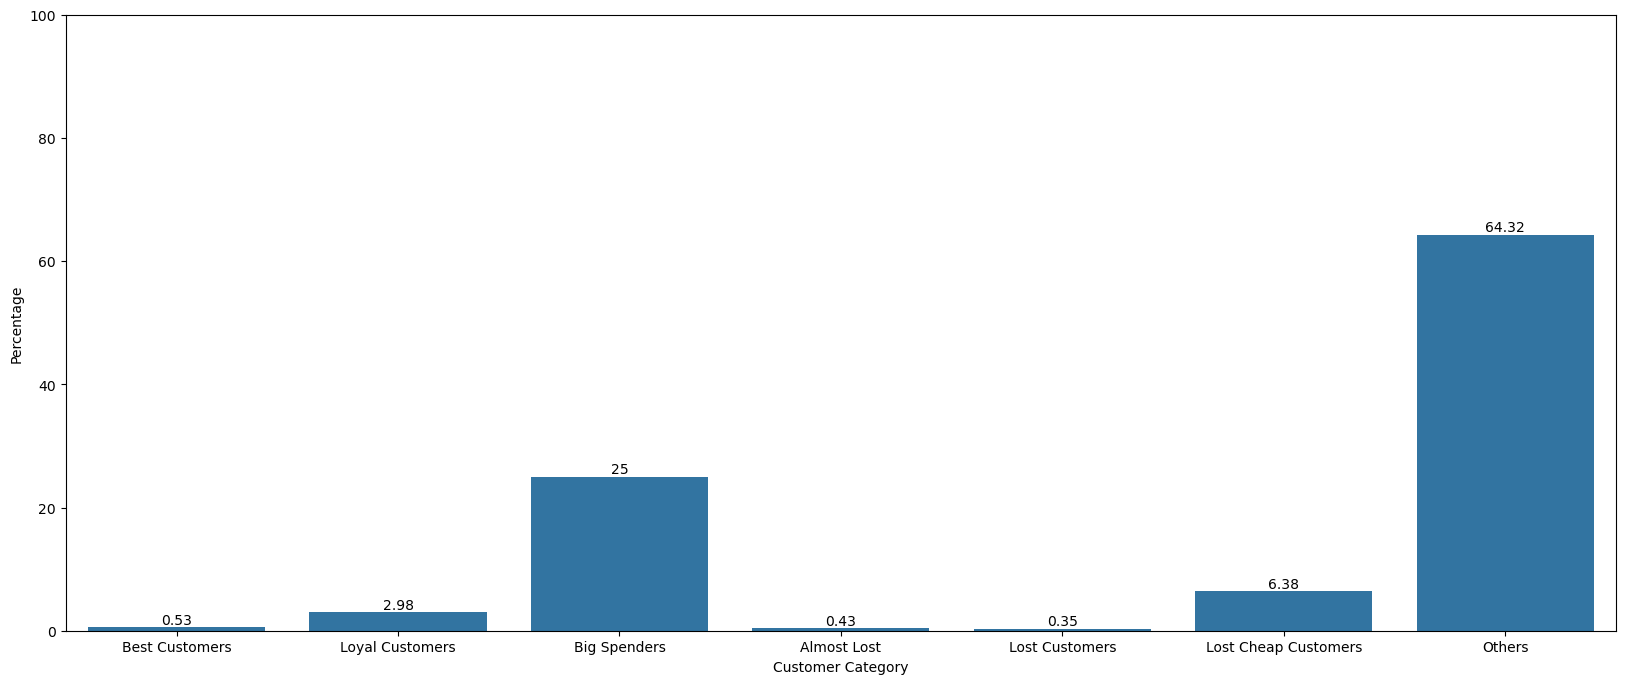

In [242]:
fig, ax = plt.subplots(figsize=(20,8))

ax = sns.barplot(data=summary_rfm, x='Customer Category', y='Percentage')

for i in ax.containers:
    ax.bar_label(i,)

plt.ylim(0,100)
plt.savefig('RFM Proportion Status.png', bbox_inches='tight')
plt.show()

- Konsumen di seluruh negara bagian yang melakukan order merupakan tipe 'Big Spenders', artinya melakukan pembelian dengan jumlah uang yang dikeluarkan cukup banyak untuk beberapa kali order.
- Namun konsumen yang masuk kategori 'Lost Cheap Customers' cukup banyak jumlahnya, yang artinya hanya sesekali melakukan order atau beberapa kali order namun tidak dalam waktu yang berdekatan.
- Kategori 'Others' mendominasi segmentasi RFM ini, artinya perlu dilakukan analisis lebih lanjut.

## **8. Modelling (Predicting Review Score)**

Pada bagian ini kita mencari model yang cocok untuk memprediksi review score pada dataset tersebut. Model yang digunakan adalah **Random Forest (Regression dan Classifier)**, **Decision Tree (Regression dan Classifier)**, dan **Logistic Regression**.

In [243]:
df_full = df_full.drop(columns=['total_spent'])

df_full.describe(include='all').T

count unique  \
order_id                            117329  97916   
customer_id                         117329  97916   
order_status                        117329      7   
order_purchase_timestamp            117329    NaN   
order_approved_at                   117314    NaN   
order_delivered_carrier_date        116094    NaN   
order_delivered_customer_date       114858    NaN   
order_estimated_delivery_date       117329    NaN   
review_id                           117329  97708   
review_score                      117329.0    NaN   
review_comment_title                 13892   4497   
review_comment_message               49679  35691   
review_creation_date                117329    NaN   
review_answer_timestamp             117329    NaN   
payment_sequential                117329.0    NaN   
payment_type                        117329      4   
payment_installments              117329.0    NaN   
payment_value                     117329.0    NaN   
customer_unique_id                  117329  94720   
customer_zip_code_prefix          117329.0    NaN   
customer_city                       117329   4108   
customer_state                      117329     27   
order_item_id                     117329.0    NaN   
product_id                          117329  32789   
seller_id                           117329   3090   
shipping_limit_date                 117329    NaN   
price                             117329.0    NaN   
freight_value                     117329.0    NaN   
product_category_name               115634     73   
product_category_name_translated    115609     71   
product_name_length               115634.0    NaN   
product_description_length        115634.0    NaN   
product_photos_qty                115634.0    NaN   
product_weight_g                  117309.0    NaN   
product_length_cm                 117309.0    NaN   
product_height_cm                 117309.0    NaN   
product_width_cm                  117309.0    NaN   
seller_zip_code_prefix            117329.0    NaN   
seller_city                         117329    611   
seller_state                        117329     23   
state_name_customer                 117329     27   
state_name_seller                   117329     23   
date_purchase                       117329    615   

                                                               top    freq  \
order_id                          895ab968e7bb0d5659d16cd74cd1650c      63   
customer_id                       270c23a11d024a44c896d1894b261a83      63   
order_status                                             delivered  114859   
order_purchase_timestamp                                       NaN     NaN   
order_approved_at                                              NaN     NaN   
order_delivered_carrier_date                                   NaN     NaN   
order_delivered_customer_date                                  NaN     NaN   
order_estimated_delivery_date                                  NaN     NaN   
review_id                         eef5dbca8d37dfce6db7d7b16dd0525e      63   
review_score                                                   NaN     NaN   
review_comment_title                                     Recomendo     494   
review_comment_message                                   Muito bom     259   
review_creation_date                                           NaN     NaN   
review_answer_timestamp                                        NaN     NaN   
payment_sequential                                             NaN     NaN   
payment_type                                           credit_card   86520   
payment_installments                                           NaN     NaN   
payment_value                                                  NaN     NaN   
customer_unique_id                9a736b248f67d166d2fbb006bcb877c3      75   
customer_zip_code_prefix                                       NaN     NaN   
customer_city                                            sao paulo

In [244]:
# Copy data for backup

df_full2 = df_full.copy()

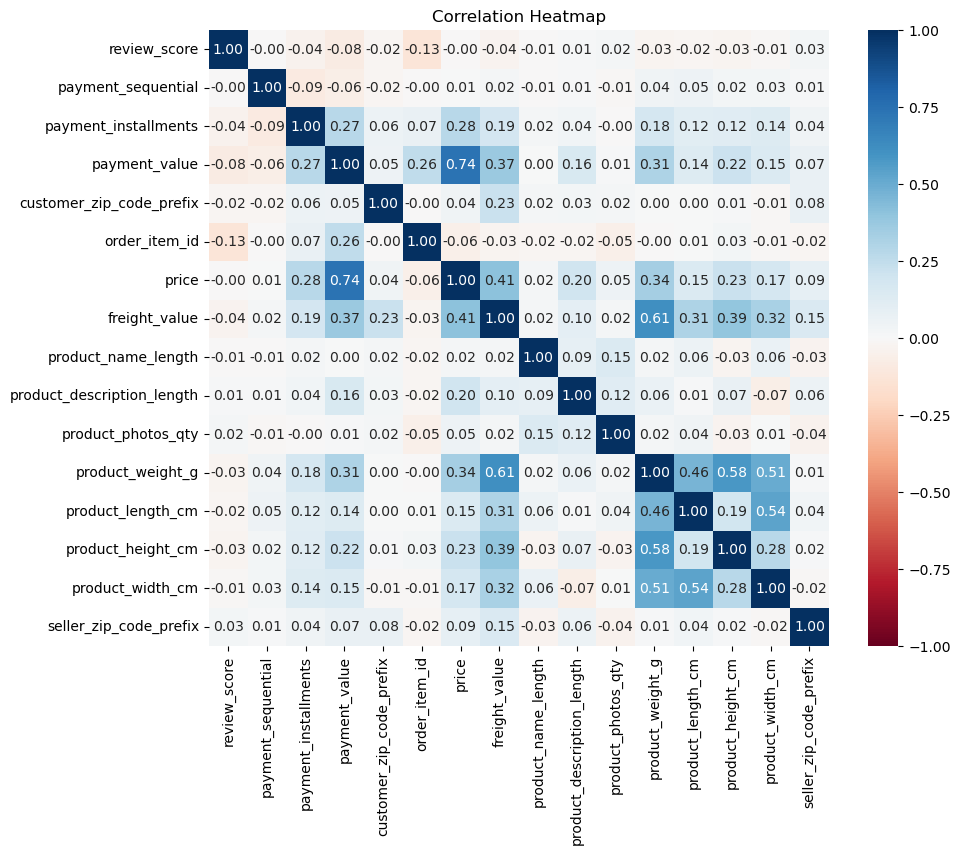

In [245]:
corr2 = df_full2.corr(numeric_only=True)

plt.figure(figsize=(10, 8))
sns.heatmap(corr2, cmap='RdBu', norm=plt.Normalize(-1,1), annot=True, fmt='.2f')
plt.title("Correlation Heatmap")
plt.show()

- Price, payment_value, freight_value dan product_weight merupakan 4 variabel yang memiliki korelasi cukup tinggi (> 0.3), sehingga kita akan mengecek outlier dari 4 variabel tersebut. 

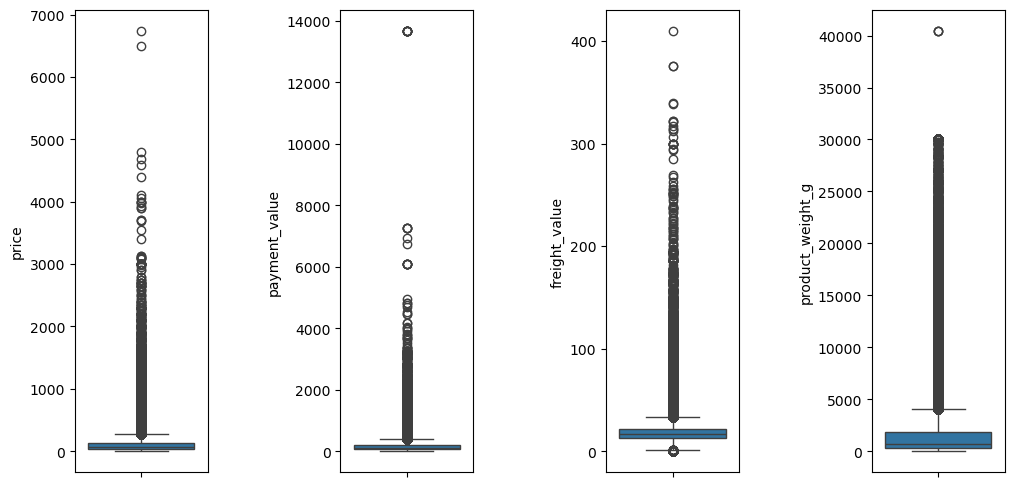

In [246]:
fig, ax = plt.subplots(ncols=4, nrows=1, figsize=(12,6))

plt.subplots_adjust(wspace=1, hspace=0.0)

sns.boxplot(df_full2['price'], ax=ax[0])
sns.boxplot(df_full2['payment_value'], ax=ax[1])
sns.boxplot(df_full2['freight_value'], ax=ax[2])
sns.boxplot(df_full2['product_weight_g'], ax=ax[3])

plt.show()

- 4 variabel di atas menunjukkan bahwa ada banyak nilai data yang di luar masing-masing boxplot. Namun disini tidak dilakukan remove outlier karena akan menghilangkan banyak informasi pada dataset tersebut.

In [247]:
df_full2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117329 entries, 0 to 117328
Data columns (total 43 columns):
 #   Column                            Non-Null Count   Dtype         
---  ------                            --------------   -----         
 0   order_id                          117329 non-null  object        
 1   customer_id                       117329 non-null  object        
 2   order_status                      117329 non-null  object        
 3   order_purchase_timestamp          117329 non-null  datetime64[ns]
 4   order_approved_at                 117314 non-null  datetime64[ns]
 5   order_delivered_carrier_date      116094 non-null  datetime64[ns]
 6   order_delivered_customer_date     114858 non-null  datetime64[ns]
 7   order_estimated_delivery_date     117329 non-null  datetime64[ns]
 8   review_id                         117329 non-null  object        
 9   review_score                      117329 non-null  int64         
 10  review_comment_title            

In [248]:
df_full2['review_score'].value_counts()

review_score
5    66264
4    22286
1    14854
3     9840
2     4085
Name: count, dtype: int64

- Total masing-masing review score memiliki perbedaan yang cukup jauh satu sama lain sehingga dapat mempengaruhi prediksi oleh model. Namun disini kita mencoba membangun model prediksi mana yang cocok untuk review score tersebut tanpa menyamaratakan jumlah total dari review score tersebut.

In [249]:
df_full_copy = df_full2.copy()

In [250]:
# Calculate delivery duration and difference between actual and estimated delivery time
df_full_copy.loc[df_full_copy['order_delivered_customer_date'].isnull(), "order_delivered_customer_date"] = df_full_copy['order_estimated_delivery_date']
df_full_copy['actual_est_delivery_diff'] = (df_full_copy['order_estimated_delivery_date'] - df_full_copy['order_delivered_customer_date']).dt.days
df_full_copy['delivery_duration'] = (df_full_copy['order_delivered_customer_date'] - df_full_copy['order_purchase_timestamp']).dt.days

In [251]:
# Encoding order status
df_full_copy.loc[df_full_copy['order_status'] == 'delivered', "if_delivered"] = 1
df_full_copy.loc[df_full_copy['order_status'] != 'delivered', "if_delivered"] = 0

In [252]:
# Encoding payment type
df_full_copy.loc[df_full_copy['payment_type'] == 'credit_card', "category_payment"] = 1
df_full_copy.loc[df_full_copy['payment_type'] != 'credit_card', "category_payment"] = 0

In [253]:
# Standardization data with z-score
df_full_copy['price_normalized'] = (df_full_copy['price'] - df_full_copy['price'].mean())/df_full_copy['price'].std()
df_full_copy['payment_value_normalized'] = (df_full_copy['payment_value'] - df_full_copy['payment_value'].mean())/df_full_copy['payment_value'].std()
df_full_copy['freight_value_normalized'] = (df_full_copy['freight_value'] - df_full_copy['freight_value'].mean())/df_full_copy['freight_value'].std()
df_full_copy['product_weight_normalized'] = (df_full_copy['product_weight_g'] - df_full_copy['product_weight_g'].mean())/df_full_copy['product_weight_g'].std()
df_full_copy['actual_est_diff_normalized'] = (df_full_copy['actual_est_delivery_diff'] - df_full_copy['actual_est_delivery_diff'].mean())/df_full_copy['actual_est_delivery_diff'].std()
df_full_copy['delivery_duration_normalized'] = (df_full_copy['delivery_duration'] - df_full_copy['delivery_duration'].mean())/df_full_copy['delivery_duration'].std()


# Drop unnecessary column
drop_column = [
    'price','payment_value','freight_value','product_weight_g','actual_est_delivery_diff','delivery_duration',
    'customer_zip_code_prefix', 'order_item_id', 'seller_zip_code_prefix', 'product_name_length', 'product_description_length', 'product_photos_qty',
    'payment_sequential', 'payment_installments', 'product_height_cm', 'product_width_cm', 'product_length_cm'
    ]
datetime_col = list(df_full2.columns[df_full2.dtypes == 'datetime64[ns]'])
obj_col = list(df_full2.columns[df_full2.dtypes == 'object'])

df_full_copy = df_full_copy.drop(columns=drop_column)
df_full_copy = df_full_copy.drop(columns=datetime_col)
df_full_copy = df_full_copy.drop(columns=obj_col)

df_full_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117329 entries, 0 to 117328
Data columns (total 9 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   review_score                  117329 non-null  int64  
 1   if_delivered                  117329 non-null  float64
 2   category_payment              117329 non-null  float64
 3   price_normalized              117329 non-null  float64
 4   payment_value_normalized      117329 non-null  float64
 5   freight_value_normalized      117329 non-null  float64
 6   product_weight_normalized     117309 non-null  float64
 7   actual_est_diff_normalized    117329 non-null  float64
 8   delivery_duration_normalized  117329 non-null  float64
dtypes: float64(8), int64(1)
memory usage: 8.1 MB


In [254]:
# Drop missing values

df_full_copy.dropna(subset=['product_weight_normalized'], inplace=True)

df_full_copy

review_score  if_delivered  category_payment  price_normalized  \
0                  4           1.0               1.0         -0.494872   
1                  4           1.0               0.0         -0.494872   
2                  4           1.0               0.0         -0.494872   
3                  4           1.0               1.0         -0.494872   
4                  5           1.0               1.0         -0.494872   
...              ...           ...               ...               ...   
117324             5           1.0               0.0         -0.226977   
117325             1           0.0               1.0         -0.551119   
117326             5           1.0               0.0          1.522184   
117327             4           1.0               1.0          0.543200   
117328             5           1.0               0.0         -0.574077   

        payment_value_normalized  freight_value_normalized  \
0                      -0.580066                 -0.714396   
1                      -0.640807                 -0.714396   
2                      -0.578295                 -0.714396   
3                      -0.506023                 -0.773784   
4                      -0.506023                 -0.773784   
...                          ...                       ...   
117324                 -0.297423                 -0.372598   
117325                 -0.532814                 -0.572875   
117326                  1.024942                  1.582156   
117327                  0.271140                  0.258559   
117328                 -0.541744                 -0.457258   

        product_weight_normalized  actual_est_diff_normalized  \
0                       -0.425550                   -0.380787   
1                       -0.425550                   -0.380787   
2                       -0.425550                   -0.380787   
3                       -0.425550                   -0.183033   
4                       -0.425550                   -0.380787   
...                           ...                         ...   
117324                  -0.359502                   -0.084157   
117325                  -0.451970                   -1.072923   
117326                  -0.002844                    0.212473   
117327                   1.001085                   -1.567307   
117328                  -0.535718                   -0.380787   

        delivery_duration_normalized  
0                          -0.443151  
1                          -0.443151  
2                          -0.443151  
3                          -1.068920  
4                          -0.756036  
...                              ...  
117324                     -0.443151  
117325                      0.599797  
117326                     -0.338857  
117327                      0.912681  
117328                     -0.756036  

[117309 rows x 9 columns]

In [255]:
X = df_full_copy.drop(columns=['review_score']) # Predictor variable
y = df_full_copy['review_score'] # Target variable

In [256]:
rf = RandomForestRegressor()
rf2 = RandomForestClassifier()
lg = LogisticRegression()
dtr = DecisionTreeRegressor()
dtc = DecisionTreeClassifier()

rf.fit(X,y)
rf2.fit(X,y)
lg.fit(X,y)
dtr.fit(X,y)
dtc.fit(X,y)

DecisionTreeClassifier()

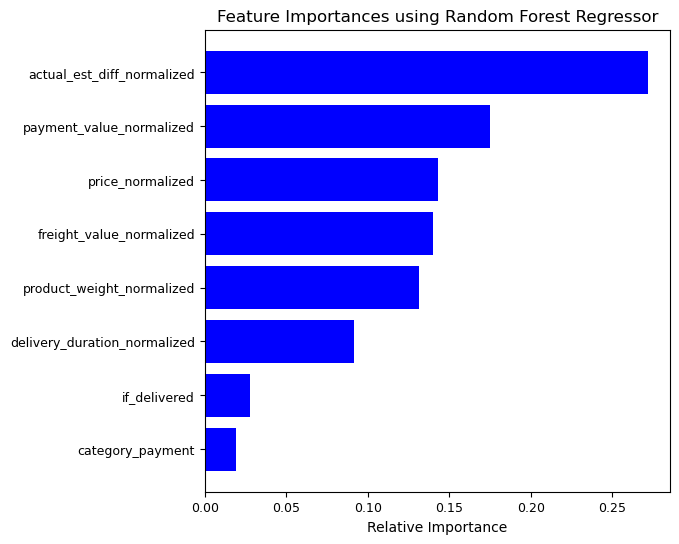

In [257]:
# Feature importance based on model Random Forest Regressor
features = list(X.columns)
importances = rf.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(6,6))
plt.title('Feature Importances using Random Forest Regressor')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.tick_params(axis='both', which='major', labelsize=9)
plt.savefig('Random Forest Regressor Feature Importance.png', bbox_inches='tight')
plt.show()

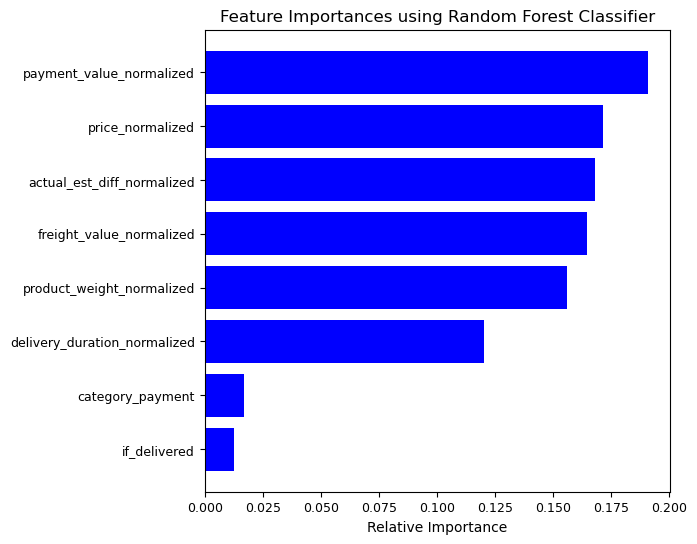

In [258]:
# Feature importance based on model Random Forest Classifier
features = list(X.columns)
importances = rf2.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(6,6))
plt.title('Feature Importances using Random Forest Classifier')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.tick_params(axis='both', which='major', labelsize=9)
plt.savefig('Random Forest Classifier Feature Importance.png', bbox_inches='tight')
plt.show()

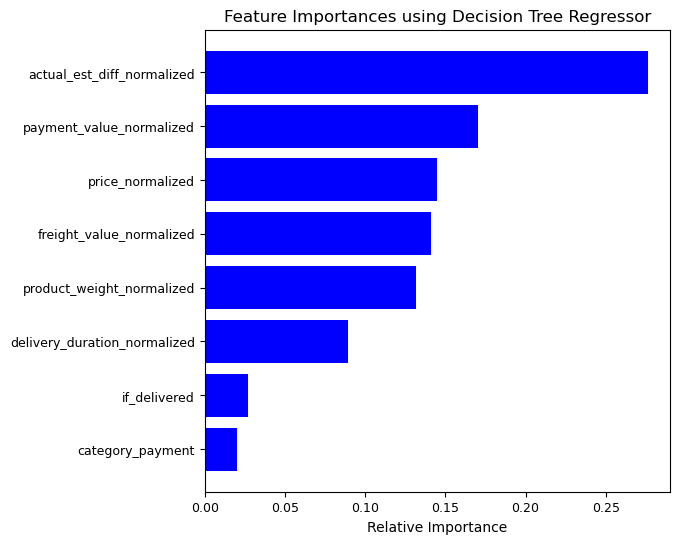

In [259]:
# Feature importance based on model Decision Tree Regressor
features = list(X.columns)
importances = dtr.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(6,6))
plt.title('Feature Importances using Decision Tree Regressor')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.tick_params(axis='both', which='major', labelsize=9)
plt.savefig('Decision Tree Regressor Feature Importance.png', bbox_inches='tight')
plt.show()

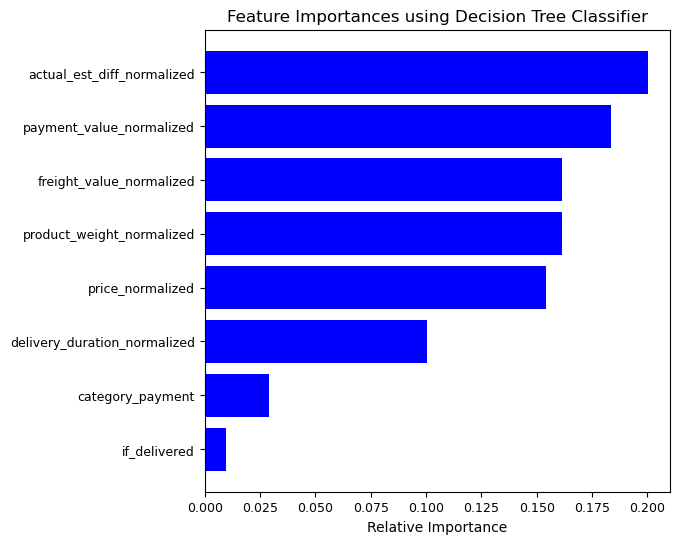

In [260]:
# Feature importance based on model Decision Tree Classifier
features = list(X.columns)
importances = dtc.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(6,6))
plt.title('Feature Importances using Decision Tree Classifier')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.tick_params(axis='both', which='major', labelsize=9)
plt.savefig('Decision Tree Classifier Feature Importance.png', bbox_inches='tight')
plt.show()

In [261]:
# Split train and test data (80% train and 20% test data)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [262]:
# Fit each model
rf_model = rf.fit(X_train, y_train)
rf2_model = rf2.fit(X_train, y_train)
lg_model = lg.fit(X_train, y_train)
dtr_model = dtr.fit(X_train, y_train)
dtc_model = dtc.fit(X_train, y_train)

# Predict on test data
y_pred_rf = rf_model.predict(X_test)
y_pred_rf2 = rf2_model.predict(X_test)
y_pred_lg = lg_model.predict(X_test)
y_pred_dtr = dtr_model.predict(X_test)
y_pred_dtc = dtc_model.predict(X_test)

# Calculate R2 Score
rf_score = rf_model.score(X_test, y_test)
rf2_score = rf2_model.score(X_test, y_test)
lg_score = lg_model.score(X_test, y_test)
dtr_score = dtr_model.score(X_test, y_test)
dtc_score = dtc_model.score(X_test, y_test)

# Calculate RMSE
rf_rmse = np.sqrt(mean_squared_error(y_test.values, y_pred_rf))
rf2_rmse = np.sqrt(mean_squared_error(y_test.values, y_pred_rf2))
lg_rmse = np.sqrt(mean_squared_error(y_test.values, y_pred_lg))
dtr_rmse = np.sqrt(mean_squared_error(y_test.values, y_pred_dtr))
dtc_rmse = np.sqrt(mean_squared_error(y_test.values, y_pred_dtc))


In [263]:
label_model_test = {
    'True Label': y_test.values,
    'Random Forest Regression': y_pred_rf,
    'Random Forest Classifier': y_pred_rf2,
    'Logistic Regression': y_pred_lg,
    'Decision Tree Regression': y_pred_dtr,
    'Decision Tree Classifier': y_pred_dtc
}

label_model_test = pd.DataFrame(label_model_test)

label_model_test.head()

True Label  Random Forest Regression  Random Forest Classifier  \
0           5                      4.57                         5   
1           4                      3.84                         5   
2           5                      4.71                         5   
3           5                      4.91                         5   
4           2                      3.84                         5   

   Logistic Regression  Decision Tree Regression  Decision Tree Classifier  
0                    5                       4.0                         5  
1                    5                       5.0                         5  
2                    5                       4.0                         5  
3                    5                       5.0                         5  
4                    5                       4.0                         4

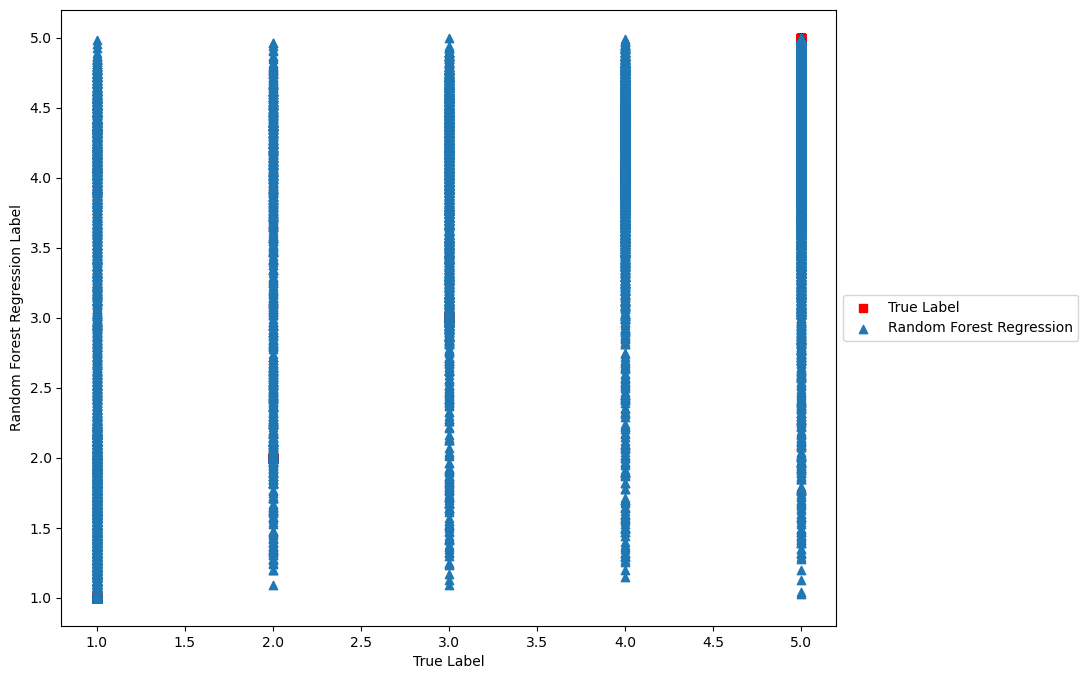

In [264]:
fig, ax = plt.subplots(figsize=(10,8))

ax.scatter(data=label_model_test, x='True Label',y='True Label', marker='s', color='r')
ax.scatter(data=label_model_test, x='True Label',y='Random Forest Regression', marker='^')
ax.set(xlabel='True Label', ylabel='Random Forest Regression Label')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


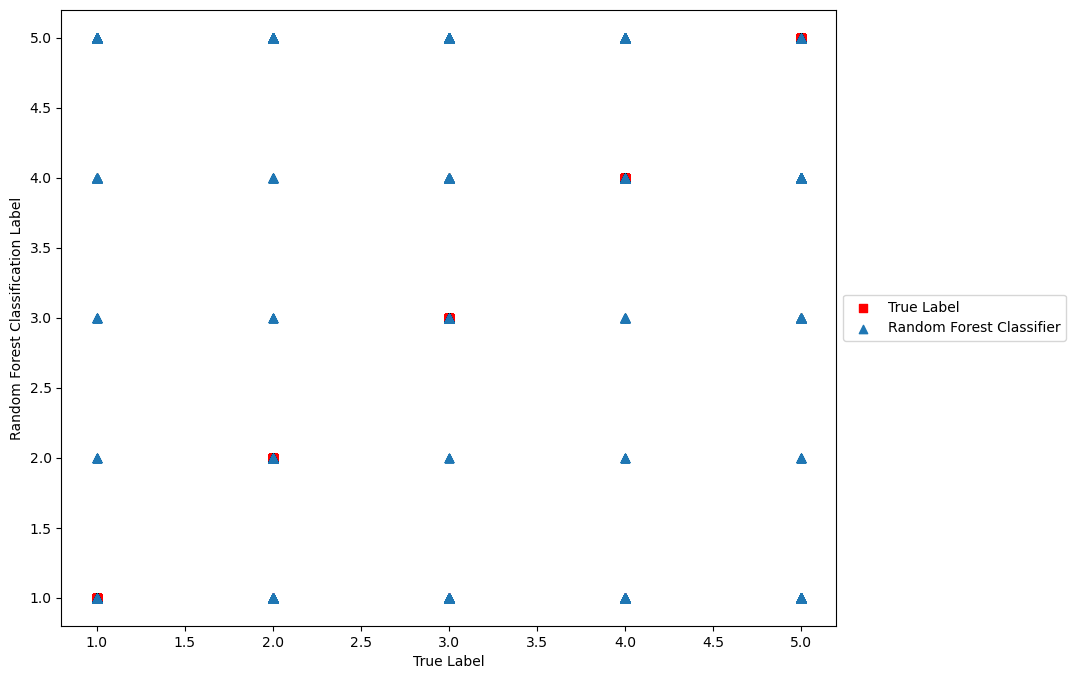

In [265]:
fig, ax = plt.subplots(figsize=(10,8))

ax.scatter(data=label_model_test, x='True Label',y='True Label', marker='s', color='r')
ax.scatter(data=label_model_test, x='True Label',y='Random Forest Classifier', marker='^')
ax.set(xlabel='True Label', ylabel='Random Forest Classification Label')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

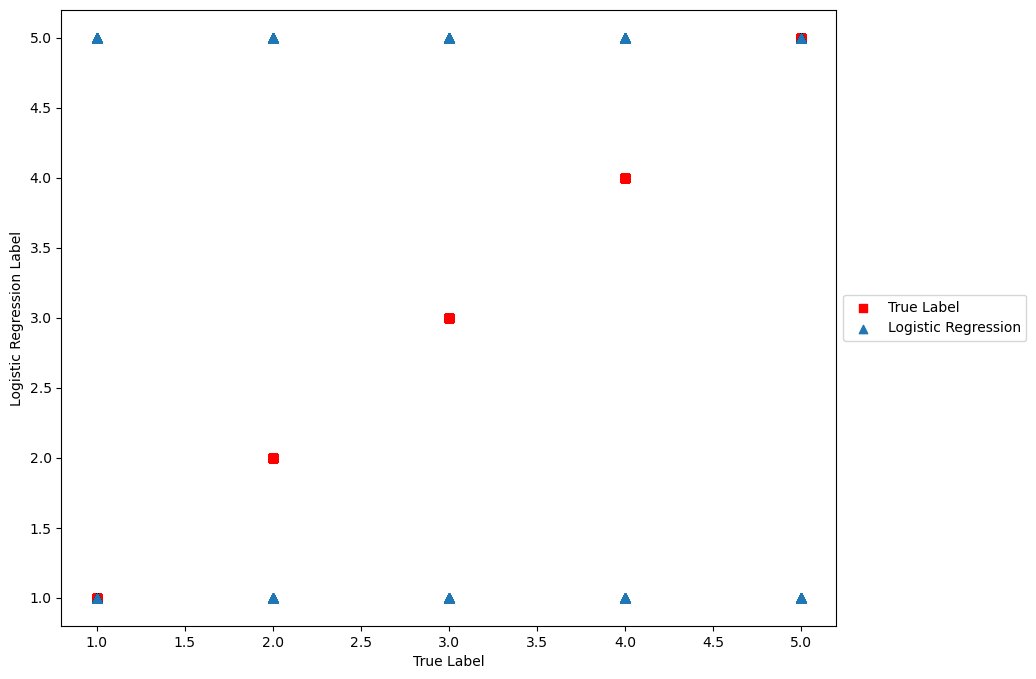

In [266]:
fig, ax = plt.subplots(figsize=(10,8))

ax.scatter(data=label_model_test, x='True Label',y='True Label', marker='s', color='r')
ax.scatter(data=label_model_test, x='True Label',y='Logistic Regression', marker='^')
ax.set(xlabel='True Label', ylabel='Logistic Regression Label')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

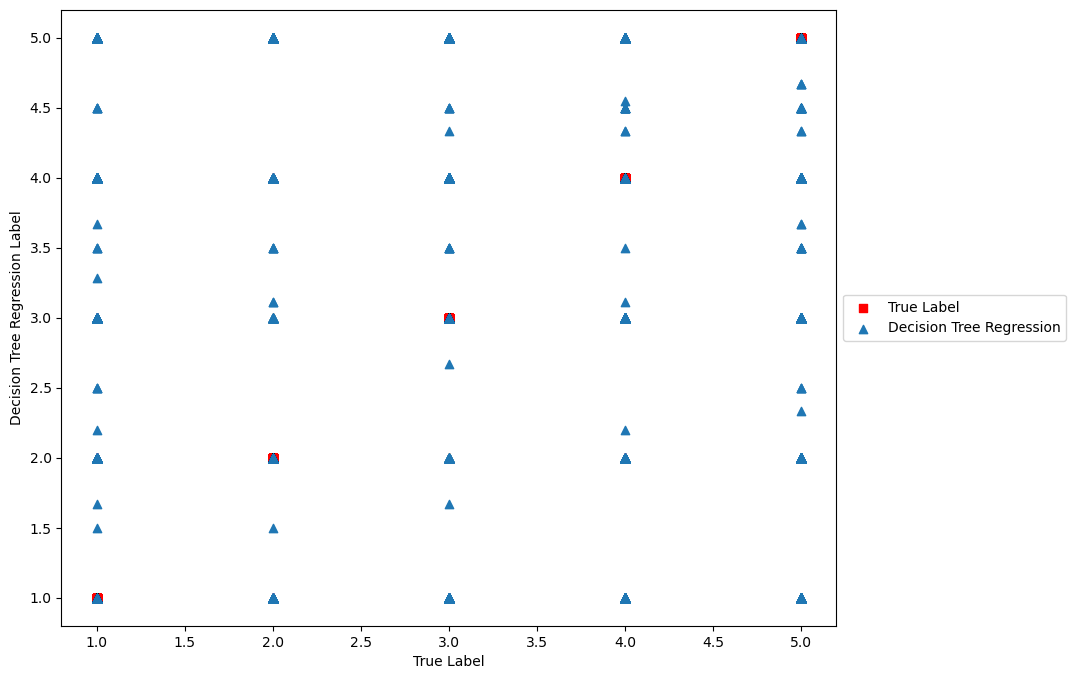

In [267]:
fig, ax = plt.subplots(figsize=(10,8))

ax.scatter(data=label_model_test, x='True Label',y='True Label', marker='s', color='r')
ax.scatter(data=label_model_test, x='True Label',y='Decision Tree Regression', marker='^')
ax.set(xlabel='True Label', ylabel='Decision Tree Regression Label')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

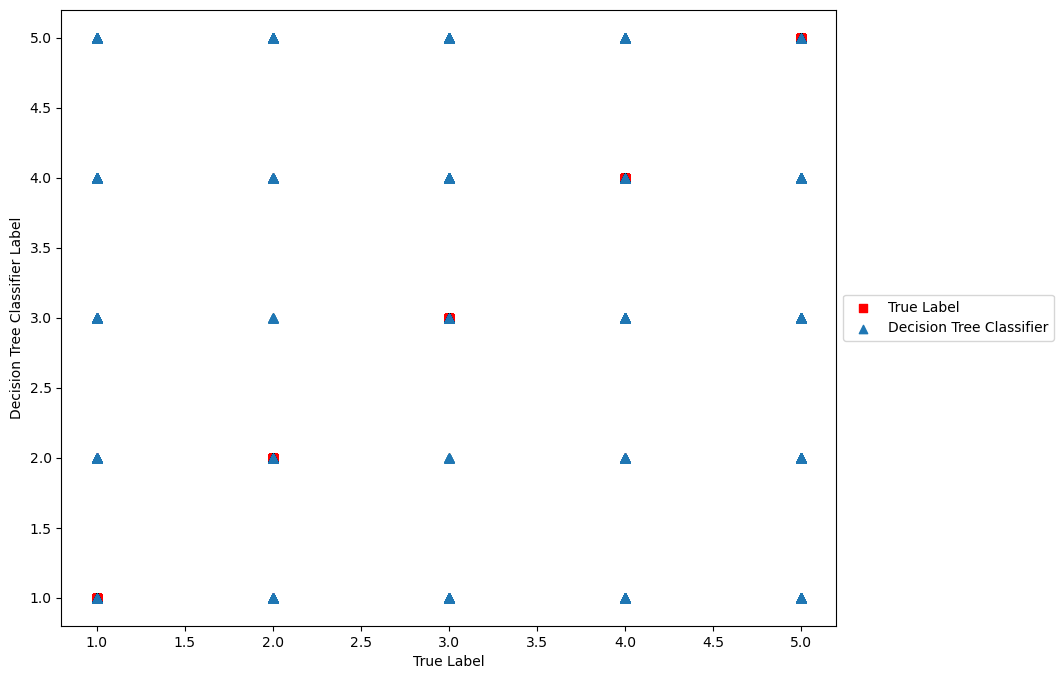

In [268]:
fig, ax = plt.subplots(figsize=(10,8))

ax.scatter(data=label_model_test, x='True Label',y='True Label', marker='s', color='r')
ax.scatter(data=label_model_test, x='True Label',y='Decision Tree Classifier', marker='^')
ax.set(xlabel='True Label', ylabel='Decision Tree Classifier Label')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [269]:
summary_model_test = {
    'Model': ['Random Forest Regression', 'Random Forest Classifier', 'Logistic Regression', 'Decision Tree Regression', 'Decision Tree Classifier'],
    'R2_Score': [rf_score, rf2_score, lg_score, dtr_score, dtc_score],
    'RMSE': [rf_rmse, rf2_rmse, lg_rmse, dtr_rmse, dtc_rmse]
}

summary_model_test = pd.DataFrame(summary_model_test)
summary_model_test

Model  R2_Score      RMSE
0  Random Forest Regression  0.386505  1.087621
1  Random Forest Classifier  0.675347  1.257778
2       Logistic Regression  0.600034  1.529133
3  Decision Tree Regression -0.139802  1.482473
4  Decision Tree Classifier  0.540917  1.481322

- Hasil prediksi model pada test data menunjukkan bahwa ada 3 kandidat model yang cocok untuk prediksi berdasarkan nilai R2 score, yaitu **Random Forest Classifier**, **Logistic Classifier**, dan **Decision Tree Classifier**
- Namun kita perlu melihat perbandingan total review score dari 3 model tersebut dengan total review score dari test data.

In [270]:
label_dtc = pd.DataFrame(label_model_test['Decision Tree Classifier'].value_counts())
label_lg = pd.DataFrame(label_model_test['Logistic Regression'].value_counts())
label_rf2 = pd.DataFrame(label_model_test['Random Forest Classifier'].value_counts())
label_true = pd.DataFrame(label_model_test['True Label'].value_counts())

label_dtc.columns = ['Count Label Decision Tree Classifier']
label_lg.columns = ['Count Label Logistic Regression']
label_rf2.columns = ['Count Label Random Forest Classifier']
label_true.columns = ['Count True Label']

In [271]:
all_count = label_true.join(label_dtc['Count Label Decision Tree Classifier'])\
            .join(label_lg['Count Label Logistic Regression'])\
            .join(label_rf2['Count Label Random Forest Classifier'])\
            .reset_index().sort_values(by=['True Label'], ignore_index=True).fillna(0)

all_count

True Label  Count True Label  Count Label Decision Tree Classifier  \
0           1              2983                                  3118   
1           2               794                                   873   
2           3              1952                                  2072   
3           4              4442                                  4652   
4           5             13291                                 12747   

   Count Label Logistic Regression  Count Label Random Forest Classifier  
0                           1651.0                                  2451  
1                              0.0                                   233  
2                              0.0                                   510  
3                              0.0                                  1594  
4                          21811.0                                 18674

- Meskipun 3 kandidat model tersebut memiliki R2 Score yang cukup baik, ternyata **Logistic Regression** gagal untuk memprediksi review score 2-4.
- Sedangkan **Random Forest Classifier** memiliki total prediksi review score yang cukup jauh dibandingkan total prediksi review score pada **Decision Tree Classifier**
- Dapat disimpulkan bahwa model **Decision Tree Classifier** cukup baik digunakan sebagai model prediksi meskipun total review score pada test data memiliki perbedaan yang cukup jauh satu sama lain 